**1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention**

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd  # ; pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split

from sklift.metrics import uplift_at_k # чтобы измерять качество аплифт 30
from sklift.viz import plot_uplift_preds # будем строить распределение предиктов
from sklift.models import SoloModel
from sklift.models import ClassTransformation
from sklift.models import TwoModels

from catboost import CatBoostClassifier


# Чтение данных
df = pd.read_csv('data.csv')

In [2]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


**2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.**

In [3]:
df = df.rename(columns={'conversion': 'target', 'offer': 'treatment'})

In [4]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [5]:
df['treatment'] = np.where((df['treatment'] == 'No Offer'), 0, 1)

In [6]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0


**3. сделать разбиение набора данных не тренировочную и тестовую выборки**

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   treatment      64000 non-null  int32  
 8   target         64000 non-null  int64  
dtypes: float64(1), int32(1), int64(5), object(2)
memory usage: 4.2+ MB


In [8]:
df.columns

Index(['recency', 'history', 'used_discount', 'used_bogo', 'zip_code',
       'is_referral', 'channel', 'treatment', 'target'],
      dtype='object')

In [9]:
num_feats = ['recency', 'history', 'used_discount', 'used_bogo', 'is_referral', 'treatment']
cat_feats = ['zip_code', 'channel']
target = 'target'
all_feats = num_feats + cat_feats

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df[all_feats], df[target], test_size = 0.3, random_state = 42)

In [11]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((44800, 8), (19200, 8), (44800,), (19200,))

**4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)**

In [12]:
X_train.recency.value_counts()

1     6276
2     5283
10    5270
9     4510
3     4063
4     3538
6     3240
5     3169
7     2892
8     2455
11    2452
12    1652
Name: recency, dtype: int64

In [13]:
# value of the historical purchases
X_train.history.describe()

count    44800.000000
mean       241.894206
std        255.238863
min         29.990000
25%         64.720000
50%        158.205000
75%        325.267500
max       3215.970000
Name: history, dtype: float64

In [14]:
X_train.used_discount.value_counts()

1    24652
0    20148
Name: used_discount, dtype: int64

In [15]:
X_train.used_bogo.value_counts()

1    24659
0    20141
Name: used_bogo, dtype: int64

In [16]:
X_train.is_referral.value_counts()

1    22440
0    22360
Name: is_referral, dtype: int64

In [17]:
X_train.zip_code.value_counts()

Surburban    20274
Urban        17824
Rural         6702
Name: zip_code, dtype: int64

In [18]:
X_train.channel.value_counts()

Web             19772
Phone           19635
Multichannel     5393
Name: channel, dtype: int64

<AxesSubplot:xlabel='recency', ylabel='history'>

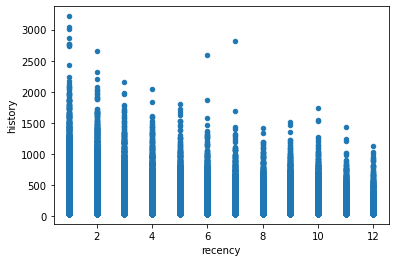

In [19]:
# months since last purchase
# value of the historical purchases
X_train.plot.scatter('recency', 'history')

Видно небольшую тенденцию - что чем больше времени прошло с последней покупки - тем меньше покупок человек в целом совершил.

И похоже есть выбросы. Значения history > 2500

<AxesSubplot:xlabel='recency', ylabel='history'>

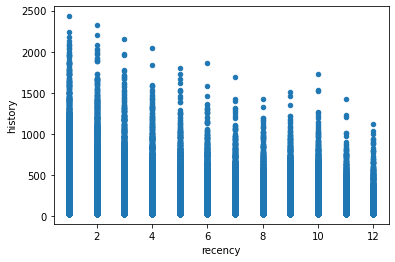

In [20]:
def clean_outlier(df, value=2500):
    
    median_value = df.loc[df['history'] < 2500, 'history'].median()
    df.loc[df['history']>2500, 'history'] = median_value
    
    return df

X_test = clean_outlier(X_test)
X_train = clean_outlier(X_train)

X_train.plot.scatter('recency', 'history')

**5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями**

In [21]:
treat_train = X_train['treatment']
treat_test = X_test['treatment']

models_results_10 = {
    'approach': [],
    'uplift@10%': []
}
models_results_20 = {
    'approach': [],
    'uplift@20%': []
}
models_results_30 = {
    'approach': [],
    'uplift@30%': []
}

### Одна модель с признаком коммуникации

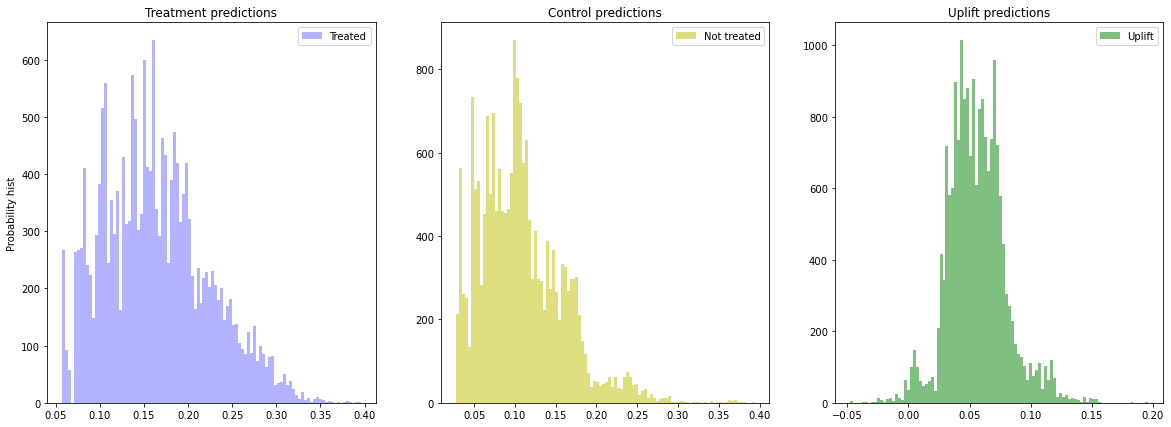

In [22]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True)) # определили модель
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_feats})
# treat_train передаем в модель знание о том было ли взаим-е с клиентом - так как модель не знает без него где флаг взаим-я

uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)
sm_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.3)


models_results_10['approach'].append('SoloModel')
models_results_10['uplift@10%'].append(sm_score_10)

models_results_20['approach'].append('SoloModel')
models_results_20['uplift@20%'].append(sm_score_20)

models_results_30['approach'].append('SoloModel')
models_results_30['uplift@30%'].append(sm_score_30)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [23]:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,is_referral,20.778102
1,treatment,17.451616
2,recency,12.316129
3,zip_code,12.233417
4,used_bogo,11.428316
5,used_discount,9.079170
6,channel,8.921914
7,history,7.791336


**Трансформация классов**

In [24]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_feats})

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)
ct_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.3)


models_results_10['approach'].append('ClassTransformation')
models_results_10['uplift@10%'].append(ct_score_10)

models_results_20['approach'].append('ClassTransformation')
models_results_20['uplift@20%'].append(ct_score_20)

models_results_30['approach'].append('ClassTransformation')
models_results_30['uplift@30%'].append(ct_score_30)

<ipython-input-24-1e3ddb39be1a>:2: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_feats})


**Две независимые модели**

array([<AxesSubplot:title={'center':'Treatment predictions'}, ylabel='Probability hist'>,
       <AxesSubplot:title={'center':'Control predictions'}>,
       <AxesSubplot:title={'center':'Uplift predictions'}>], dtype=object)

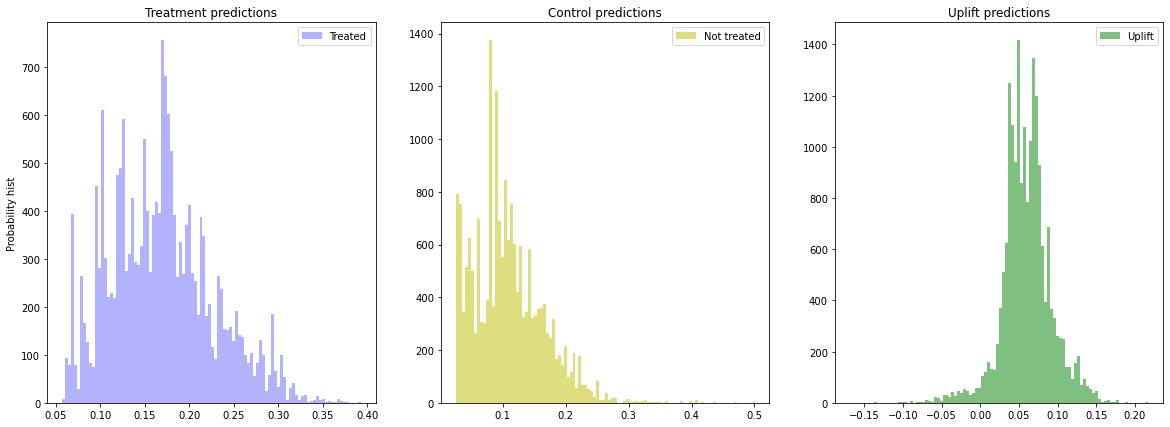

In [25]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_feats}, 
    estimator_ctrl_fit_params={'cat_features': cat_feats}
)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)
tm_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.3)

models_results_10['approach'].append('TwoModels')
models_results_10['uplift@10%'].append(tm_score_10)

models_results_20['approach'].append('TwoModels')
models_results_20['uplift@20%'].append(tm_score_20)

models_results_30['approach'].append('TwoModels')
models_results_30['uplift@30%'].append(tm_score_30)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_)

**6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей**

In [26]:
res10 = pd.DataFrame(models_results_10)
res20 = pd.DataFrame(models_results_20)
res30 = pd.DataFrame(models_results_30)

results = res10.merge(res20, how="left", on=["approach"]).merge(res30, how="left", on=["approach"])
results

,approach,uplift@10%,uplift@20%,uplift@30%
0,SoloModel,0.116699,0.098680,0.096586
1,ClassTransformation,0.263279,0.222239,0.193727
2,TwoModels,0.091547,0.087252,0.090220


Результаты без FeatureEngineering были лучше - на нормальный нет времени

approach	uplift@10%	uplift@20%	uplift@30%

0	SoloModel	0.122913	0.100633	0.092650

1	ClassTransformation	0.273450	0.227711	0.197113

2	TwoModels	0.109515	0.091545	0.078819

**7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево**

In [27]:
# %cd causalml
# !pip install -r requirements.txt


C:\Users\gribanov\PycharmProjects\04_ml_business\lection4_materials\causalml


In [29]:
!python setup.py build_ext --inplace

Compiling causalml/inference/tree/causaltree.pyx because it changed.
[1/1] Cythonizing causalml/inference/tree/causaltree.pyx
running build_ext
building 'causalml.inference.tree.causaltree' extension


C:\Users\gribanov\anaconda3\lib\site-packages\Cython\Compiler\Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\gribanov\PycharmProjects\04_ml_business\lection4_materials\causalml\causalml\inference\tree\causaltree.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
error: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/
